En este notebook se desarrollan los gráficos que se usarán en la parte de resultados del TFM

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets import daocensus, daocensus_text, to_microsoft
from src import paths

In [2]:
ORGS = [
    ('snapshot', 'Decentraland'),
    ('snapshot', 'PancakeSwap'),
    ('daostack', 'xDXdao'),
]

ORG_NAME = ORGS[0][1]
ORG_PLATFORM = ORGS[0][0]

SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE: bool = True
HYBRID_MERGE = 'naive'

# Exploración de datos de Decentraland

In [3]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, ORG_PLATFORM)
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')
# dfp = dfp.set_index('id')
dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  category      
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 7.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1943 entries, 0f4784fc-022a-5047-8bfe-e16ac3bd0984 to 629184e6-f8b2-5270-b358-252369d7599d
Data columns (total 12 column

In [4]:
print(f"{ORG_NAME} tiene {len(dfv)} votos de {dfv['voter'].nunique()} voters en {dfv['proposal'].nunique()} propuestas")

Decentraland tiene 116560 votos de 7268 voters en 1942 propuestas


## ¿Suelen votarse las propuestas más al principio o al final?

2021-12-10 16:21:00 2021-12-17 16:21:00 7 days 00:00:00


<Axes: title={'center': 'Propuesta b86aa059-3d31-5d41-a472-70962816f779'}, xlabel='date_rel', ylabel='Count'>

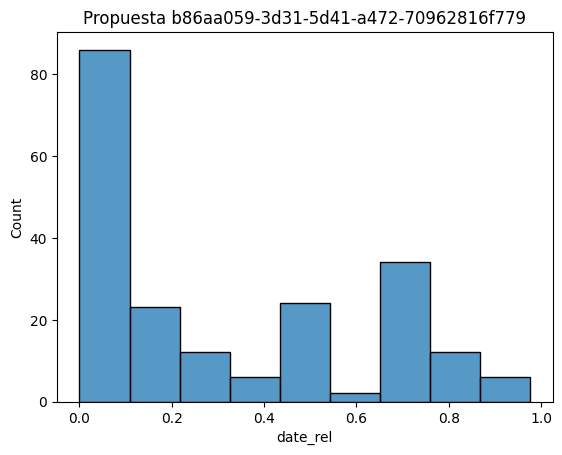

In [5]:
def proposal_histogram(proposal):
    p = dfp.loc[proposal]
    _aux = dfv[dfv["proposal"] == proposal][['platform', 'name', 'date']].copy().sort_values('date')
    first_vote = p['start']
    last_vote = p['end']
    print(p['start'], p['end'], p['end'] - p['start'])
    _aux['date_rel'] = (_aux['date'] - p['start']) / (p['end'] - p['start'])
    # sns.ecdfplot(_aux['date_rel'])
    ax = sns.histplot(_aux['date_rel'])
    ax.set_title(f"Propuesta {proposal}")
    return ax

proposal_histogram(proposal = "b86aa059-3d31-5d41-a472-70962816f779")

### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Sin embargo, este gráfico puede estar sesgado por una propuesta, vamos a intentar hacerlo relativo

Text(0.5, 1.0, 'Histograma de todos los votos realizados en Decentraland')

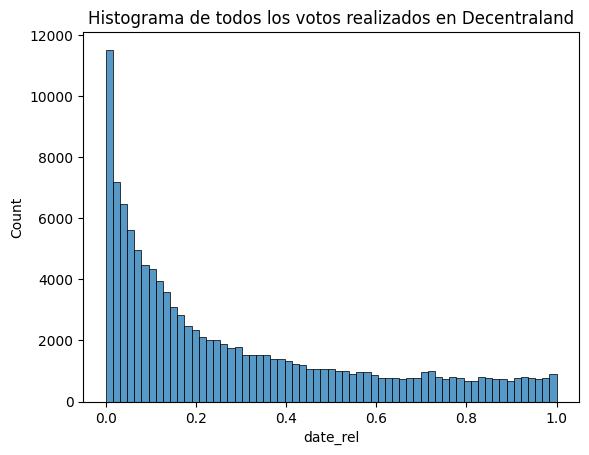

In [6]:
_dfv = dfv[['platform', 'name', 'proposal', 'date']].merge(dfp[['start', 'end']], left_on='proposal', right_index=True).sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
ax = sns.histplot(_dfv, x='date_rel')
ax.set_title(f"Histograma de todos los votos realizados en {ORG_NAME}")

In [7]:
_dfv[['date_rel']].describe(percentiles=[.1,.25,.5,.75,.78,.8])

,date_rel
count,116560.000000
mean,0.284883
std,0.279415
min,0.000008
10%,0.016169
25%,0.058511
50%,0.175888
75%,0.449425
78%,0.501090
80%,0.538141


In [8]:
# _dfv.groupby('proposal')['date_rel'].describe().describe()

### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Vamos a intentar calcular la frecuencia relativa acumulada

In [9]:
rel = (1 / _dfv.groupby('proposal').size()).rename('freq')
_dfv2 = _dfv.join(rel, on='proposal')
_dfv2['cumfreq'] = _dfv2.groupby('proposal')['freq'].cumsum()
_dfv2

,platform,name,proposal,date,start,end,date_rel,freq,cumfreq
10527,snapshot,Decentraland,312c5654-0806-5473-8243-dbd6311208ed,2021-05-24 15:29:29,2021-05-24 15:29:00,2021-05-31 15:29:00,0.000048,0.058824,0.058824
31518,snapshot,Decentraland,f6bd4c7d-0d1e-5437-9cf9-e5e883522d3f,2021-05-24 15:30:54,2021-05-24 15:30:00,2021-05-31 15:30:00,0.000089,0.045455,0.045455
69100,snapshot,Decentraland,2dc28092-bb92-5c3f-8837-f8ed570d1a20,2021-05-24 15:38:54,2021-05-24 15:38:00,2021-05-31 15:38:00,0.000089,0.038462,0.038462
69099,snapshot,Decentraland,2dc28092-bb92-5c3f-8837-f8ed570d1a20,2021-05-24 15:41:31,2021-05-24 15:38:00,2021-05-31 15:38:00,0.000349,0.038462,0.076923
37507,snapshot,Decentraland,94c28bf3-501e-5925-98a3-b4ddbed07abf,2021-05-24 15:50:36,2021-05-24 15:49:00,2021-05-31 15:49:00,0.000159,0.050000,0.050000
...,...,...,...,...,...,...,...,...,...
69192,snapshot,Decentraland,e5fcfaed-fd89-547f-aba0-b682b2114a4b,2023-07-19 16:19:59,2023-07-06 15:59:00,2023-07-20 15:59:00,0.929612,0.006849,0.993151
72239,snapshot,Decentraland,f41ed318-2f75-5a16-a798-6623e99fb55a,2023-07-19 17:54:31,2023-07-06 15:28:00,2023-07-20 15:28:00,0.935839,0.008772,0.991228
57127,snapshot,Decentraland,858339c3-6902-52c5-ab98-bb5985327cbd,2023-07-19 17:57:35,2023-07-06 15:12:00,2023-07-20 15:12:00,0.936785,0.006944,1.000000
72238,snapshot,Decentraland,f41ed318-2f75-5a16-a798-6623e99fb55a,2023-07-20 00:56:09,2023-07-06 15:28:00,2023-07-20 15:28:00,0.956753,0.008772,1.000000


In [10]:
_dfv2.groupby('proposal').size().sort_values()

proposal
7dbd97bd-b0d6-50bc-a0fb-4e87995fd8bc      0
2f1659a4-c5ce-59a5-8192-ac1cf108ad08      0
3e792f17-8f94-5b85-809e-73779a2930e7      0
469346d6-6ba2-5236-b085-b4459ddead9c      0
9953ea21-0357-502c-ab3b-96638300da49      0
                                       ... 
6a88aec3-b179-56da-b9c0-d7072299b987    344
5ba291bd-b9e5-526f-82ab-9e55ce1d297c    365
ef768acf-0eb6-56a6-9d94-bfc6422deb83    372
b32ce381-23e2-538b-8ff9-33205b457c22    382
433b7e43-77b0-5ea1-bac3-0c3071363a56    385
Length: 2194, dtype: int64

### KDE plot de las más votadas

Text(0.5, 1.0, 'kde plot de las 15 propuestas más grandes en Decentraland')

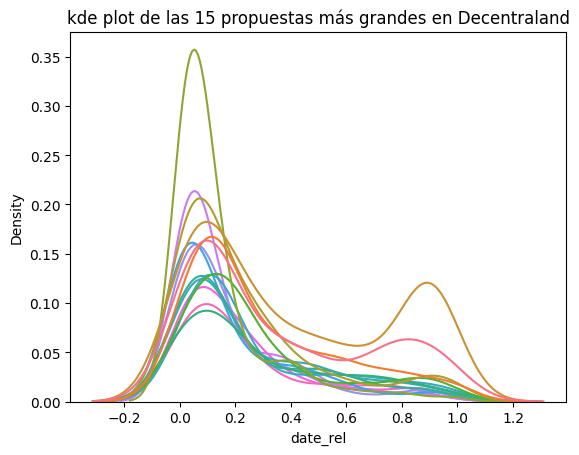

In [11]:
# Get N random proposals
# proposals = np.random.choice(_dfv2['proposal'].unique(), 15, replace=False, p=_dfv2.groupby('proposal').size() / _dfv2.groupby('proposal').size().sum())

# Get top N proposals
proposals = _dfv2.groupby('proposal').size().tail(15).index

_toplot = _dfv2[_dfv2['proposal'].isin(proposals)].copy()
_toplot['proposal'] = _toplot['proposal'].astype(str)
assert _toplot['proposal'].nunique() == len(proposals)
sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")

Efectivamente, los votos se realizan sobre todo nada más crearse la propuesta. El 25% de los votos ya han sido emitidos cuando aún queda un 95% del tiempo restante, y solo un 22% votan en la segunda mitad del tiempo disponible. Sin embargo, como podemos observar en la figura de `[kde plot de las 15 propuestas más grandes]`, hay propuestas en las que al final puede haber un pequeño repunte de actividad. Recordemos que en las DAOs el resultado de la votación es siempre visible, lo que puede sesgar la participación si los usuarios piensan que el resultado es estable y no va a cambiar.

Al partir el dataset en puntos aleatorios considerando una distribución uniforme, lo más seguro es que nos encontremos que las propuestas con las que entrenamos y testeamos (las _frontera_), tengan, en general más votos en el conjunto de entrenamiento que en el de test. Por esta razón también es necesario un sistema que sea muy resiliente al problema de cold start.

## Cuantas propuestas tenemos para entrenar en el dataset

In [12]:
from src.model_selection import timeFreqSplitCurrent, filter_current
from collections import defaultdict

In [13]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(10)
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2023-W19,18,1627,358,90.39,4.54,322,130,17.89,2.48
2023-W20,25,1346,305,53.84,4.41,713,147,28.52,4.85
2023-W21,19,1483,305,78.05,4.86,296,108,15.58,2.74
2023-W22,13,819,247,63.00,3.32,267,89,20.54,3.00
2023-W23,13,631,191,48.54,3.30,291,94,22.38,3.10
2023-W24,16,872,225,54.50,3.88,326,110,20.38,2.96
2023-W25,17,1136,278,66.82,4.09,331,127,19.47,2.61
2023-W26,10,838,278,83.80,3.01,204,92,20.40,2.22
2023-W27,21,1591,469,75.76,3.39,683,198,32.52,3.45


In [14]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2023-W19 & 18 & 1627 & 358 & 90.39 & 4.54 & 322 & 130 & 17.89 & 2.48 \\
2023-W20 & 25 & 1346 & 305 & 53.84 & 4.41 & 713 & 147 & 28.52 & 4.85 \\
2023-W21 & 19 & 1483 & 305 & 78.05 & 4.86 & 296 & 108 & 15.58 & 2.74 \\
2023-W22 & 13 & 819 & 247 & 63.00 & 3.32 & 267 & 89 & 20.54 & 3.00 \\
2023-W23 & 13 & 631 & 191 & 48.54 & 3.30 & 291 & 94 & 22.38 & 3.10 \\
2023-W24 & 16 & 872 & 225 & 54.50 & 3.88 & 326 & 110 & 20.38 & 2.96 \\
2023-W25 & 17 & 1136 & 278 & 66.82 & 4.09 & 331 & 127 & 19.47 & 2.61 \\
2023-W26 & 10 & 838 & 278 & 83.80 & 3.01 & 204 & 92 & 20.40 & 2.22 \\
2023-W27 & 21 & 1591 & 469 & 75.76 & 3.39 & 683 & 198 & 32.52 & 3.45 \\
2023-W28 & 

In [15]:
sdf.describe()

,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,17.500000,1892.600000,110875.000000,1283.600000,325.600000,381.500000,6986.300000,123.600000,72.309672,3.896316,21.428901,3.010979
std,4.719934,33.002357,3083.717454,552.792949,123.245194,173.231541,117.242436,33.230508,18.695872,0.618609,5.281827,0.732419
min,10.000000,1838.000000,106129.000000,631.000000,191.000000,204.000000,6863.000000,89.000000,48.538462,3.014388,15.578947,2.217391
25%,13.750000,1870.250000,108990.500000,846.500000,254.750000,292.250000,6912.500000,97.500000,56.625000,3.334923,18.284314,2.632029
50%,17.500000,1893.000000,110722.500000,1241.000000,291.500000,324.000000,6946.000000,118.500000,71.292717,3.980943,20.387500,2.852189
75%,20.500000,1913.500000,112720.000000,1564.000000,344.750000,369.250000,7028.250000,138.250000,82.363158,4.348586,21.923077,3.071809
max,25.000000,1941.000000,115984.000000,2493.000000,600.000000,713.000000,7234.000000,198.000000,108.391304,4.862295,32.523810,4.850340


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2023-W19'),
  Text(1, 0, '2023-W20'),
  Text(2, 0, '2023-W21'),
  Text(3, 0, '2023-W22'),
  Text(4, 0, '2023-W23'),
  Text(5, 0, '2023-W24'),
  Text(6, 0, '2023-W25'),
  Text(7, 0, '2023-W26'),
  Text(8, 0, '2023-W27'),
  Text(9, 0, '2023-W28')])

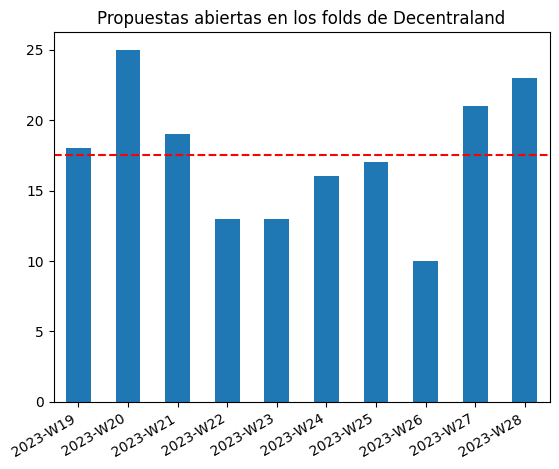

In [16]:
ax = sdf[['open proposals']].plot.bar(legend=False, xlabel='')
plt.axhline(sdf['open proposals'].mean(), c='red', linestyle='--')
ax.set_title(f'Propuestas abiertas en los folds de {ORG_NAME}')
ax.set_xticklabels(sdf.index.strftime('%G-W%V'))
plt.xticks(rotation=30, ha='right')
# TODO: Pintar horizonte con la media

<Axes: xlabel='t'>

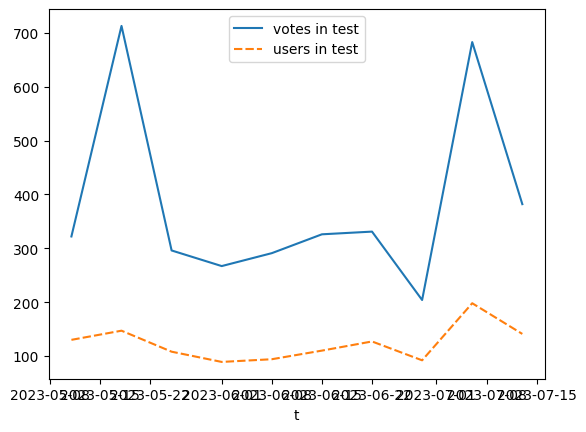

In [17]:
sns.lineplot(sdf[[
    # 'users in train (filtered)', 'votes in train (filtered)', 
    'votes in test', 'users in test',
]])

### Numero de propuestas relevantes
Además del número de propuestas abiertas, queremos saber cual es la _precision@k_ máxima, para ello es necesario saber no sólo el número de propuestas abiertas, si no en cuantas de esas propuestas votaron los usuarios. En términos de IR, necesitamos saber cual es el número de documentos relevantes, que seguramente sea menor que el número de documentos recuperados.

In [18]:
sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']
sdf

/tmp/ipykernel_3947204/710207913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf['vpu in test'] = sdf['votes in test'] / sdf['users in test']


,open proposals,proposals in train,votes in train,votes in open proposals (train),users in open proposals (train),votes in test,users in train,users in test,vpp in open proposals (train),vpu in open proposals (train),vpp test,vpu test,vpu in test
t,,,,,,,,,,,,,
2023-05-11,18,1838,106129,1627,358,322,6863,130,90.388889,4.544693,17.888889,2.476923,2.476923
2023-05-18,25,1859,107387,1346,305,713,6886,147,53.840000,4.413115,28.520000,4.850340,4.850340
2023-05-25,19,1868,108802,1483,305,296,6910,108,78.052632,4.862295,15.578947,2.740741,2.740741
2023-06-01,13,1877,109556,819,247,267,6920,89,63.000000,3.315789,20.538462,3.000000,3.000000
2023-06-08,13,1886,110250,631,191,291,6937,94,48.538462,3.303665,22.384615,3.095745,3.095745
2023-06-15,16,1900,111195,872,225,326,6955,110,54.500000,3.875556,20.375000,2.963636,2.963636
2023-06-22,17,1909,112105,1136,278,331,6987,127,66.823529,4.086331,19.470588,2.606299,2.606299
2023-06-29,10,1915,112925,838,278,204,7042,92,83.800000,3.014388,20.400000,2.217391,2.217391
2023-07-06,21,1933,114417,1591,469,683,7129,198,75.761905,3.392324,32.523810,3.449495,3.449495


# Recomendador GNN

In [23]:
dfh = pd.read_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, HYBRID_MERGE))
dfg = dfh[dfh['model'] == 'gnn'].reset_index(drop=True)
dfg

,t,precision@5,ndcg@5,map@5,precision@10,ndcg@10,map@10,model
0,2023-05-11,0.238462,0.449218,0.379061,0.179231,0.519369,0.431245,gnn
1,2023-05-18,0.304762,0.362381,0.222491,0.262585,0.418517,0.300198,gnn
2,2023-05-25,0.268519,0.468798,0.374712,0.197222,0.526746,0.430628,gnn
3,2023-06-01,0.334831,0.468570,0.385756,0.257303,0.578833,0.482223,gnn
4,2023-06-08,0.361702,0.514303,0.399822,0.277660,0.616718,0.495909,gnn
5,2023-06-15,0.281818,0.406015,0.307328,0.236364,0.524370,0.396819,gnn
6,2023-06-22,0.255118,0.424000,0.337316,0.185827,0.487304,0.392077,gnn
7,2023-06-29,0.328261,0.621583,0.532555,0.221739,0.714881,0.600192,gnn
8,2023-07-06,0.225253,0.344630,0.230980,0.208586,0.436014,0.303570,gnn
9,2023-07-13,0.197163,0.340205,0.246473,0.178014,0.445308,0.315489,gnn


# Recomendador Híbrido

In [ ]:
dfm_baseline = pd.read_csv(f'./data/baseline/mp-freq-{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_baseline['model'] = 'mp'
dfm_all = pd.read_csv(f'./data/results/hybrid/{ORG_NAME}-{SPLITS_FREQ}.csv')
dfm_all = pd.concat((dfm_all, dfm_baseline))
dfm_all